# Benchmarks

These benchmarks seek to establish the performance of tablite as a user sees it.

Overview

|Input/Output|Various column functions|Base functions|Core functions|
|---|---|---|---|
|- Save / Load .tpz format<br>- Save tables to various formats<br>- Import data from various formats|- Setitem / getitem<br>- iter<br>- equal, not equal<br>- copy<br>- t += t<br>- t *= t<br>- contains<br>- remove all<br>- replace<br>- index<br>- unique<br>- histogram<br>- statistics<br>- count<br>|- Setitem / getitem<br>- iter / rows<br>- equal, not equal<br>- load<br>- save<br>- copy<br>- stack<br>- types<br>- display_dict<br>- show<br>- to_dict<br>- as_json_serializable<br>- index|- expression<br>- filter<br>- sort_index<br>- reindex<br>- drop_duplicates<br>- sort<br>- is_sorted<br>- any<br>- all<br>- drop <br>- replace<br>- groupby<br>- pivot<br>- joins<br>- lookup<br>- replace missing values<br>- transpose<br>- pivot_transpose<br>- diff|


In [2]:
import psutil, os, gc, shutil, tempfile
from pathlib import Path
from time import perf_counter, time
from tablite import Table
from tablite.datasets import synthetic_order_data
from tablite.config import Config

Config.TQDM_DISABLE = True

## Input / Output

### Create tables from synthetic data.

In [3]:
process = psutil.Process(os.getpid())

def make_tables(sizes=[1,2,5,10,20,50]):
    # The last tables are too big for RAM (~24Gb), so I create subtables of 1M rows and append them.
    t = synthetic_order_data(Config.PAGE_SIZE)
    real, flat = t.nbytes()
    print(f"Table {len(t):,} rows is {real/1e6:,.0f} Mb on disk")

    tables = [t]  # 1M rows.

    last = 1
    t2 = t.copy()
    for i in sizes[1:]:
        t2 = t2.copy()
        for _ in range(i-last):
            t2 += synthetic_order_data(Config.PAGE_SIZE)  # these are all unique
        last = i
        real, flat = t2.nbytes()
        tables.append(t2)
        print(f"Table {len(t2):,} rows is {real/1e6:,.0f} Mb on disk")
    return tables

tables = make_tables()

Table 1,000,000 rows is 256 Mb on disk
Table 2,000,000 rows is 512 Mb on disk
Table 5,000,000 rows is 1,280 Mb on disk
Table 10,000,000 rows is 2,560 Mb on disk
Table 20,000,000 rows is 5,120 Mb on disk
Table 50,000,000 rows is 12,800 Mb on disk


The values in the tables above are all unique!

In [4]:
tables[-1]

~,#,1,2,3,4,5,6,7,8,9,10,11
0,1,1401495318295,2021-10-06T00:00:00,50814,1,19375,C3-4,HGQ,21°,XYZ,1.2446472682017344,21.367107051830455
1,2,932023137218,2021-08-26T00:00:00,50077,1,8568,C5-5,FZU,0°,,0.5529448534751613,2.6980406874392537
2,3,1256960225081,2021-12-21T00:00:00,50197,0,29074,C2-3,GTK,6°,XYZ,1.997397545590656,17.513164305723787
3,4,1401277781743,2021-08-23T00:00:00,50818,0,24969,C4-3,BYP,6°,XYZ,0.04749712553828957,7.388171617130485
4,5,942666767426,2021-07-31T00:00:00,50307,1,13074,C5-2,CCC,21°,ABC,1.021921502761288,5.21324123446987
5,6,1218613185127,2021-12-01T00:00:00,50484,1,17249,C5-4,WGT,21°,,0.20387642584345567,12.190974436133764
6,7,607042434398,2021-11-29T00:00:00,50578,0,11564,C2-3,LUL,0°,XYZ,2.236783515848044,4.340628097363572
...,...,...,...,...,...,...,...,...,...,...,...,...
"49,999,993",999994,660269377547,2021-09-17T00:00:00,50154,0,9706,C4-3,AHQ,21°,XYZ,0.08321664584312585,6.567802977527905
"49,999,994",999995,570979864695,2021-08-01T00:00:00,50149,1,25006,C1-2,FWH,6°,,1.0476392366226641,9.507105444627065


### Save / Load .tpz format

Without default compression settings (10% slower than uncompressed, 20% of uncompressed filesize)

In [5]:
def save_load_benchmarks(tables):
    tmp = Path(tempfile.gettempdir()) / "junk"
    tmp.mkdir(exist_ok=True)

    results = Table()
    results.add_columns('rows', 'save (sec)', 'load (sec)')
    for t in tables:
        fn = tmp / f'{len(t)}.tpz'
        start = perf_counter()
        t.save(fn)
        end = perf_counter()
        save = round(end-start,3)
        assert fn.exists()
        
        
        start = perf_counter()
        t2 = Table.load(fn)
        end = perf_counter()
        load = round(end-start,3)
        print(f"saving {len(t):,} rows ({fn.stat().st_size/1e6:,.0f} Mb) took {save:,.3f} seconds. loading took {load:,.3f} seconds")
        del t2
        fn.unlink()
        results.add_rows(len(t), save, load)
    
    r = results
    r['save r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['save (sec)']) ]
    r['load r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['load (sec)'])]

    return results


In [6]:
slb = save_load_benchmarks(tables)

saving 1,000,000 rows (49 Mb) took 2.148 seconds. loading took 0.922 seconds
saving 2,000,000 rows (98 Mb) took 4.267 seconds. loading took 1.820 seconds
saving 5,000,000 rows (246 Mb) took 10.618 seconds. loading took 4.482 seconds
saving 10,000,000 rows (492 Mb) took 21.291 seconds. loading took 8.944 seconds
saving 20,000,000 rows (984 Mb) took 42.603 seconds. loading took 17.821 seconds
saving 50,000,000 rows (2,461 Mb) took 106.644 seconds. loading took 44.600 seconds


In [7]:
slb

#,rows,save (sec),load (sec),save r/sec,load r/sec
0,1000000,2.148,0.922,465549,1084598
1,2000000,4.267,1.82,468713,1098901
2,5000000,10.618,4.482,470898,1115573
3,10000000,21.291,8.944,469682,1118067
4,20000000,42.603,17.821,469450,1122271
5,50000000,106.644,44.6,468849,1121076


With various compression options

In [8]:
def save_compression_benchmarks(t):
    tmp = Path(tempfile.gettempdir()) / "junk"
    tmp.mkdir(exist_ok=True)

    import zipfile  # https://docs.python.org/3/library/zipfile.html#zipfile.ZipFile
    methods = [(None, zipfile.ZIP_STORED, "zip stored"), (None, zipfile.ZIP_LZMA, "zip lzma")]
    methods += [(i, zipfile.ZIP_DEFLATED, "zip deflated") for i in range(0,10)]
    methods += [(i, zipfile.ZIP_BZIP2, "zip bzip2") for i in range(1,10)]

    results = Table()
    results.add_columns('file size (Mb)', 'method', 'write (sec)', 'read (sec)')
    for level, method, name in methods:
        fn = tmp / f'{len(t)}.tpz'
        start = perf_counter()  
        t.save(fn, compression_method=method, compression_level=level)
        end = perf_counter()
        write = round(end-start,3)
        assert fn.exists()
        size = int(fn.stat().st_size/1e6)
        # print(f"{name}(level={level}): {len(t):,} rows ({size} Mb) took {write:,.3f} secconds to save", end='')
        
        start = perf_counter()
        t2 = Table.load(fn)
        end = perf_counter()
        read = round(end-start,3)
        # print(f" and {end-start:,.3} seconds to load")
        print(".", end='')
        
        del t2
        fn.unlink()
        results.add_rows(size, f"{name}(level={level})", write, read)
        
    
    r = results
    r.sort({'write (sec)':True})
    r['write (rps)'] = [int(1_000_000/b) for b in r['write (sec)']]
    r['read (rps)'] = [int(1_000_000/b) for b in r['read (sec)']]
    return results

In [9]:
scb = save_compression_benchmarks(tables[0])

.....................

creating sort index: 100%|██████████| 1/1 [00:00<00:00, 268.92it/s]


In [10]:
scb[0:20]

#,file size (Mb),method,write (sec),read (sec),write (rps),read (rps)
0,256,zip stored(level=None),0.396,0.475,2525252,2105263
1,29,zip lzma(level=None),95.137,2.228,10511,448833
2,256,zip deflated(level=0),0.535,0.595,1869158,1680672
3,49,zip deflated(level=1),2.15,0.922,465116,1084598
4,47,zip deflated(level=2),2.264,0.912,441696,1096491
5,43,zip deflated(level=3),3.049,0.83,327976,1204819
6,44,zip deflated(level=4),2.92,0.862,342465,1160092
7,42,zip deflated(level=5),4.034,0.869,247892,1150747
8,40,zip deflated(level=6),8.558,0.8,116849,1250000
9,39,zip deflated(level=7),13.695,0.778,73019,1285347


**Conclusions**

- Fastest: zip stored with no compression takes handles 

### Save / load tables to / from various formats

The handlers for saving / export are:

- to_sql
- to_json
- to_xls
- to_ods
- to_csv
- to_tsv
- to_text
- to_html
- to_hdf5


In [11]:
def to_sql_benchmark(t, rows=1_000_000):
    t2 = t[:rows]
    write_start = time()
    _ = t2.to_sql(name='1')
    write_end = time()
    write = round(write_end-write_start,3)
    return ( t.to_sql.__name__, write, 0, len(t2), "" , "" ) 

In [12]:
def to_json_benchmark(t, rows=1_000_000):
    t2 = t[:rows]

    tmp = Path(tempfile.gettempdir()) / "junk"
    tmp.mkdir(exist_ok=True)
    path = tmp / "1.json" 
    
    write_start = time()
    bytestr = t2.to_json()
    with path.open('w') as fo:
        fo.write(bytestr)
    write_end = time()
    write = round(write_end-write_start,3)

    read_start = time()
    with path.open('r') as fi:
        _ = Table.from_json(fi.read())  # <-- JSON
    read_end = time()
    read = round(read_end-read_start,3)

    return ( t.to_json.__name__, write, read, len(t2), int(path.stat().st_size/1e6), "" ) 

In [13]:
def f(t, args):
    rows, c1, c1_kw, c2, c2_kw = args
    t2 = t[:rows]

    call = getattr(t2, c1)
    assert callable(call)

    write_start = time()
    call(**c1_kw)
    write_end = time()
    write = round(write_end-write_start,3)

    for _ in range(10):
        gc.collect()

    read_start = time()
    if callable(c2):
        c2(**c2_kw)
    read_end = time()
    read = round(read_end-read_start,3)

    fn = c2_kw['path']
    assert fn.exists()
    fs = int(fn.stat().st_size/1e6)
    config = {k:v for k,v in c2_kw.items() if k!= 'path'}

    return ( c1, write, read, len(t2), fs , str(config))


In [14]:
def import_export_benchmarks(tables):
    Config.PROCESSING_MODE = Config.FALSE
        
    t = sorted(tables, key=lambda x: len(x), reverse=True)[0]
    
    tmp = Path(tempfile.gettempdir()) / "junk"
    tmp.mkdir(exist_ok=True)   

    args = [
        (   100_000, "to_xlsx", {'path': tmp/'1.xlsx'}, Table.from_file, {"path":tmp/'1.xlsx', "sheet":"pyexcel_sheet1"}),
        (    50_000,  "to_ods",  {'path': tmp/'1.ods'}, Table.from_file, {"path":tmp/'1.ods', "sheet":"pyexcel_sheet1"} ),  # 50k rows, otherwise MemoryError.
        ( 1_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv'}                           ),
        ( 1_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv', "guess_datatypes":False}),
        (10_000_000,  "to_csv",  {'path': tmp/'1.csv'}, Table.from_file, {"path":tmp/'1.csv', "guess_datatypes":False}),
        ( 1_000_000,  "to_tsv",  {'path': tmp/'1.tsv'}, Table.from_file, {"path":tmp/'1.tsv'}                           ),
        ( 1_000_000, "to_text",  {'path': tmp/'1.txt'}, Table.from_file, {"path":tmp/'1.txt'}                           ),
        ( 1_000_000, "to_html", {'path': tmp/'1.html'}, Table.from_file, {"path":tmp/'1.html'}                          ),
        ( 1_000_000, "to_hdf5", {'path': tmp/'1.hdf5'}, Table.from_file, {"path":tmp/'1.hdf5'}                          )
    ]

    results = Table()
    results.add_columns('method', 'write (s)', 'read (s)', 'rows', 'size (Mb)', 'config')

    results.add_rows( to_sql_benchmark(t) )
    results.add_rows( to_json_benchmark(t) )

    for arg in args:
        if len(t)<arg[0]:
            continue
        print(".", end='')
        try:
            results.add_rows( f(t, arg) )
        except MemoryError:
            results.add_rows( arg[1], "Memory Error", "NIL", args[0], "NIL", "N/A")
    
    r = results
    r['read r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['read (s)']) ]
    r['write r/sec'] = [int(a/b) if b!=0  else "nil" for a,b in zip(r['rows'], r['write (s)'])]

    shutil.rmtree(tmp)
    return results

In [15]:
ieb = import_export_benchmarks(tables)

.........writing 12,000,000 records to /tmp/junk/1.hdf5... done


In [16]:
ieb

#,method,write (s),read (s),rows,size (Mb),config,read r/sec,write r/sec
0,to_sql,12.345,0,1000000,,,nil,81004
1,to_json,10.814,4.406,1000000,142,,226963,92472
2,to_xlsx,10.569,21.572,100000,9,{'sheet': 'pyexcel_sheet1'},4635,9461
3,to_ods,29.175,29.487,50000,3,{'sheet': 'pyexcel_sheet1'},1695,1713
4,to_csv,14.315,15.731,1000000,108,{},63568,69856
5,to_csv,14.438,8.169,1000000,108,{'guess_datatypes': False},122414,69261
6,to_csv,140.645,99.45,10000000,1080,{'guess_datatypes': False},100553,71100
7,to_tsv,13.834,15.763,1000000,108,{},63439,72285
8,to_text,13.937,15.682,1000000,108,{},63767,71751
9,to_html,12.578,0.53,1000000,228,{},1886792,79503


**Conclusions**

Best:
- to/from JSON wins with 2.3M rps read
- to/from CSV/TSV/TEXT comes 2nd with config `guess_datatypes=False` with ~ 100k rps

Worst:
- to/from ods burst the memory footprint and hence had to be reduced to 100k rows. It also had the slowest read rate with 1450 rps.


## Various column functions

- Setitem / getitem
- iter
- equal, not equal
- copy
- t += t
- t *= t
- contains
- remove all
- replace
- index
- unique
- histogram
- statistics
- count

In [17]:
def contains_benchmark(table):
    results = Table()
    results.add_columns( "column", "time (s)" )
    for name,col in table.columns.items():
        n = len(col)
        start,stop,step = int(n*0.02), int(n*0.98), int(n/100)
        selection = col[start:stop:step]
        total_time = 0.0
        for v in selection:
            start_time = perf_counter()
            v in col  # <--- test!
            end_time = perf_counter()
            total_time += (end_time - start_time)
        avg_time = total_time / len(selection)
        results.add_rows( name, round(avg_time,3) )

    return results
    

In [18]:
has_it = contains_benchmark(tables[-1])
has_it

#,column,time (s)
0,#,0.001
1,1,0.043
2,2,0.032
3,3,0.001
4,4,0.001
5,5,0.001
6,6,0.006
7,7,0.003
8,8,0.006
9,9,0.007


## Various table functions

### Slicing

Slicing operations are used in many places.

In [19]:
def slicing_benchmark(table):
    n = len(table)
    start,stop,step = int(0.02*n), int(0.98*n), int(n / 20)  # from 2% to 98% in 20 large steps
    start_time = perf_counter()
    snip = table[start:stop:step]
    end_time = perf_counter()
    print(f"reading {len(table):,} rows to find {len(snip):,} rows took {end_time-start_time:.3f} sec")
    return snip

In [20]:
slice_it = slicing_benchmark(tables[-1])

reading 50,000,000 rows to find 20 rows took 1.435 sec


In [22]:
def column_selection_benchmark(tables):
    results = Table()
    results.add_columns( 'rows')
    results.add_columns(*[f"n cols={i}" for i,_ in enumerate(tables[0].columns,start=1)])

    for table in tables:
        rr = [len(table)]
        for ix, name in enumerate(table.columns):
            cols = list(table.columns)[:ix+1]
            start_time = perf_counter()
            table[cols]
            end_time = perf_counter()
            rr.append(f"{end_time-start_time:.5f}")
        results.add_rows( rr )
    return results

In [23]:
csb = column_selection_benchmark(tables)
print("times below are are in seconds")
csb

times below are are in seconds


#,rows,n cols=1,n cols=2,n cols=3,n cols=4,n cols=5,n cols=6,n cols=7,n cols=8,n cols=9,n cols=10,n cols=11,n cols=12
0,1000000,0.00001,0.00006,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004
1,2000000,0.00001,0.00008,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00004,0.00004
2,5000000,0.00001,0.00005,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004
3,10000000,0.00002,0.00005,0.00004,0.00004,0.00004,0.00004,0.00007,0.00005,0.00005,0.00005,0.00005,0.00005
4,20000000,0.00003,0.00006,0.00005,0.00005,0.00005,0.00005,0.00006,0.00006,0.00006,0.00006,0.00006,0.00006
5,50000000,0.00009,0.00011,0.00010,0.00009,0.00009,0.00009,0.00009,0.00009,0.00009,0.00009,0.00010,0.00009


In [33]:
def iterrows_benchmark(table):
    results = Table()
    results.add_columns( 'n columns', 'time (s)')

    columns = ['1']
    for column in list(table.columns):
        columns.append(column)
        snip = table[columns, slice(500_000,1_500_000)]
        start_time = perf_counter()
        counts = 0
        for row in snip.rows:
            counts += 1
        end_time = perf_counter()
        results.add_rows( len(columns), round(end_time-start_time,3))

    return results


In [34]:
iterb = iterrows_benchmark(tables[-1])
iterb

#,n columns,time (s)
0,2,9.951
1,3,9.816
2,4,9.859
3,5,9.93
4,6,9.985
5,7,9.942
6,8,9.958
7,9,9.867
8,10,9.96
9,11,9.932


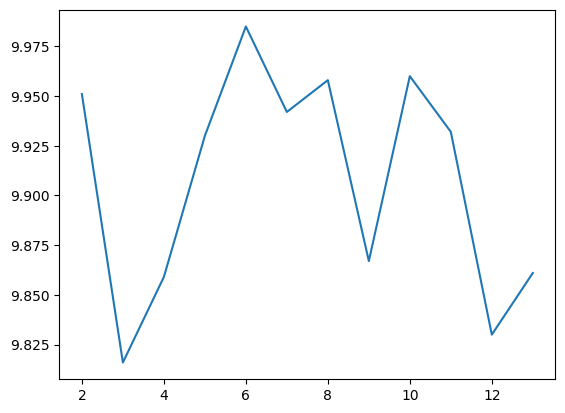

In [35]:
import matplotlib.pyplot as plt
plt.plot(iterb['n columns'], iterb['time (s)'])
plt.show()


### Table.types()

Table.types() is implemented for near constant speed lookup.

Here is an example:

In [28]:
tables[-1].types()

{'#': {int: 50000000},
 '1': {int: 50000000},
 '2': {str: 50000000},
 '3': {int: 50000000},
 '4': {int: 50000000},
 '5': {int: 50000000},
 '6': {str: 50000000},
 '7': {str: 50000000},
 '8': {str: 50000000},
 '9': {str: 50000000},
 '10': {float: 50000000},
 '11': {str: 50000000}}

In [29]:
def dtypes_benchmark(tables):
    dtypes_results = Table()
    dtypes_results.add_columns("rows", "time (s)")

    for table in tables:
        start_time = perf_counter()
        dt = table.types()
        end_time = perf_counter()
        assert isinstance(dt, dict) and len(dt) != 0
        dtypes_results.add_rows( len(table), round(end_time-start_time, 3) )

    return dtypes_results

In [30]:
dtype_b = dtypes_benchmark(tables)
dtype_b

#,rows,time (s)
0,1000000,0.0
1,2000000,0.0
2,5000000,0.0
3,10000000,0.0
4,20000000,0.0
5,50000000,0.001


### Table.any

In [31]:
def any_benchmark(tables):
    results = Table()
    results.add_columns("rows", *list(tables[0].columns))

    for table in tables:
        tmp = [len(table)]
        for column in list(table.columns):
            v = table[column][0]
            start_time = perf_counter()
            _ = table.any(**{column: v})
            end_time = perf_counter()           
            tmp.append(round(end_time-start_time,3))

        results.add_rows( tmp )
    return results


In [32]:

anyb = any_benchmark(tables)
anyb

~,rows,#,1,2,3,4,5,6,7,8,9,10,11
0,1000000,0.133,0.133,0.178,0.133,0.292,0.147,0.169,0.143,0.227,0.259,0.146,0.17
1,2000000,0.268,0.263,0.343,0.265,0.567,0.294,0.335,0.275,0.464,0.523,0.289,0.323
2,5000000,0.669,0.653,0.914,0.669,1.436,0.723,0.838,0.694,1.174,1.335,0.678,0.818
3,10000000,1.314,1.35,1.745,1.336,2.902,1.49,1.683,1.414,2.354,2.618,1.343,1.536
4,20000000,2.556,2.534,3.337,2.602,5.645,2.827,3.225,2.646,4.514,5.08,2.693,3.083
5,50000000,6.571,6.423,8.455,6.699,14.484,7.989,7.798,6.259,10.989,12.48,6.732,7.767


### Table.all

In [36]:
def all_benchmark(tables):
    results = Table()
    results.add_columns("rows", *list(tables[0].columns))

    for table in tables:
        tmp = [len(table)]
        for column in list(table.columns):
            v = table[column][0]
            start_time = perf_counter()
            _ = table.all(**{column: v})
            end_time = perf_counter()           
            tmp.append(round(end_time-start_time,3))

        results.add_rows( tmp )
    return results


In [37]:
allb = all_benchmark(tables)
allb

~,rows,#,1,2,3,4,5,6,7,8,9,10,11
0,1000000,0.12,0.121,0.162,0.122,0.264,0.138,0.155,0.127,0.209,0.237,0.133,0.151
1,2000000,0.237,0.235,0.311,0.238,0.52,0.266,0.297,0.341,0.451,0.53,0.261,0.285
2,5000000,0.675,0.698,0.952,0.594,1.605,0.659,0.812,0.719,1.224,1.353,0.664,0.914
3,10000000,1.314,1.332,1.707,1.332,3.091,1.463,1.781,1.366,2.358,2.638,1.409,1.714
4,20000000,2.576,2.313,3.11,2.396,5.207,2.573,2.921,2.403,4.041,4.658,2.463,2.808
5,50000000,5.896,5.82,7.73,5.956,12.909,7.45,7.27,5.981,10.183,11.576,6.372,7.414


### Table.filter

### Table.unique

In [38]:
def unique_benchmark(tables):
    results = Table()
    results.add_columns("rows", *list(tables[0].columns))
    
    for table in tables:
        length = len(table)

        tmp = [len(table)]
        for column in list(table.columns):
            start_time = perf_counter()
            try:
                L = table[column].unique()
                dt = perf_counter() - start_time
            except MemoryError:
                dt = -1
            tmp.append(round(dt,3))
            assert 0 < len(L) <= length    

        results.add_rows( tmp )
    return results

In [39]:
ubm = unique_benchmark(tables)
ubm

~,rows,#,1,2,3,4,5,6,7,8,9,10,11
0,1000000,0.022,0.081,0.248,0.044,0.016,0.061,0.115,0.136,0.096,0.085,0.094,0.447
1,2000000,0.176,0.271,0.505,0.087,0.031,0.124,0.229,0.279,0.198,0.17,0.305,1.471
2,5000000,0.198,0.499,1.263,0.218,0.076,0.311,0.57,0.685,0.474,0.425,0.595,2.744
3,10000000,0.502,1.123,2.535,0.433,0.155,0.615,1.128,1.375,0.96,0.85,1.316,5.826
4,20000000,0.956,2.336,5.035,0.883,0.319,1.229,2.268,2.748,1.913,1.746,2.733,11.883
5,50000000,2.395,6.019,12.499,2.178,0.764,3.073,5.608,6.819,4.828,4.279,7.097,30.511


### Table.index

Single column index first:

In [40]:
def index_benchmark(tables):
    results = Table()
    results.add_columns("rows", *list(tables[0].columns))
    
    for table in tables:

        tmp = [len(table)]
        for column in list(table.columns):
            start_time = perf_counter()
            try:
                _ = table.index(column)
                dt = perf_counter() - start_time
            except MemoryError:
                dt = -1
            tmp.append(round(dt,3))
            
        results.add_rows( tmp )
    return results  

In [41]:
ibm = index_benchmark(tables)
ibm

~,rows,#,1,2,3,4,5,6,7,8,9,10,11
0,1000000,1.949,1.793,1.432,1.106,1.051,1.23,1.338,1.493,1.411,1.303,1.999,2.325
1,2000000,2.883,3.517,2.856,2.217,2.124,2.462,2.676,2.986,2.709,2.606,4.049,4.461
2,5000000,6.382,9.049,7.096,5.628,5.353,6.312,6.649,7.521,6.71,6.459,10.27,10.747
3,10000000,12.553,18.506,13.95,11.335,10.724,12.509,13.33,15.051,13.502,12.899,19.769,21.999
4,20000000,24.717,37.896,28.568,22.666,21.472,26.327,27.157,30.064,27.332,25.822,38.311,43.399
5,50000000,63.016,97.077,72.007,55.609,54.099,61.797,68.236,75.07,69.022,66.152,99.183,109.969


Multi-column index next:

In [42]:
def multi_column_index_benchmark(tables):
    
    selection = ["4", "7", "8", "9"]
    results = Table()
    results.add_columns("rows", *range(1,len(selection)+1))
    
    for table in tables:

        tmp = [len(table)]
        for index in range(1,5):
            start_time = perf_counter()
            try:
                _ = table.index(*selection[:index])
                dt = perf_counter() - start_time
            except MemoryError:
                dt = -1
            tmp.append(round(dt,3))
            print('.', end='')
            
        results.add_rows( tmp )
    return results  

In [43]:
mcib = multi_column_index_benchmark(tables)
mcib

........................

#,rows,1,2,3,4
0,1000000,1.058,2.133,3.215,4.052
1,2000000,2.12,4.278,6.546,8.328
2,5000000,5.303,10.89,16.693,20.793
3,10000000,10.581,22.407,33.462,41.91
4,20000000,21.064,45.954,67.781,84.828
5,50000000,52.347,109.551,166.6,211.053


### drop duplicates

In [44]:
def drop_duplicates_benchmark(tables):
    results = Table()
    results.add_columns("rows", *list(tables[0].columns))
    
    for table in tables:
        result = [len(table)]
        cols = []
        for name in list(table.columns):
            cols.append(name)
            start_time = perf_counter()
            try:
                _ = table.drop_duplicates(*cols)
                dt = perf_counter() - start_time
            except MemoryError:
                dt = -1
            result.append(round(dt,3))
            print('.', end='')
        
        results.add_rows( result )
    return results  

In [45]:
ddb = drop_duplicates_benchmark(tables)
ddb

........................................................................

~,rows,#,1,2,3,4,5,6,7,8,9,10,11
0,1000000,1.761,2.358,3.313,3.901,4.615,4.961,5.835,6.534,7.454,8.108,8.803,9.682
1,2000000,3.011,4.93,6.934,7.97,9.264,10.268,12.006,13.517,14.92,16.631,17.932,19.493
2,5000000,6.827,13.853,18.637,21.237,24.548,27.11,31.157,35.026,38.992,43.531,46.022,50.433
3,10000000,13.238,31.746,41.141,46.917,53.172,58.241,67.992,74.651,82.74,91.458,97.666,104.82
4,20000000,25.932,77.75,100.34,109.314,123.514,131.874,148.432,163.57,179.121,196.047,208.686,228.059
5,50000000,64.237,312.222,364.886,388.249,429.724,466.685,494.418,535.367,581.666,607.306,634.343,683.858
